<a href="https://colab.research.google.com/github/Nikhileswar-Komati/100D_ML/blob/master/Hackathons/BIGMART_SALES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
files.upload()

In [ ]:
train_df = pd.read_csv('/content/BigMart_Train.csv')
test_df = pd.read_csv('/content/BigMart_Test.csv')
train_df['Source'] = 'Train'
test_df['Source'] = 'Test'
data = pd.concat([train_df, test_df])
print(train_df.shape, test_df.shape, data.shape)
data.sample(5)

(8523, 13) (5681, 12) (14204, 13)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Source
5389,DRE60,9.395,Low Fat,0.159984,Soft Drinks,225.4720,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN,Test
730,FDJ03,12.350,Regular,0.072542,Dairy,48.5692,OUT045,2002,NaN,Tier 2,Supermarket Type1,886.8456,Train
1938,FDR58,6.675,Low Fat,0.042159,Snack Foods,90.8462,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN,Test
987,FDR14,11.650,Low Fat,0.174016,Dairy,55.9298,OUT035,2004,Small,Tier 2,Supermarket Type1,NaN,Test
7326,FDM25,10.695,Regular,0.060913,Breakfast,173.8712,OUT018,2009,Medium,Tier 3,Supermarket Type2,4570.0512,Train


###MISSING-VALUES

In [ ]:
impute_weights = data.pivot_table(values = 'Item_Weight', index = 'Item_Identifier')
count = 0
for i, row in data.loc[data['Item_Weight'].isnull(), :].iterrows():
  x = row['Item_Identifier']
  if x in impute_weights.index:
    count += 1
    data.loc[i,'Item_Weight'] = impute_weights.loc[x].values[0]
print("IMPUTED VALUES", count)



IMPUTED VALUES 2439


In [ ]:
from scipy.stats import mode
impute_sizes = data.pivot_table(values = 'Outlet_Size', index = ['Outlet_Type', 'Outlet_Location_Type'], aggfunc = (lambda x: mode(x).mode[0]))
impute_sizes.loc[('Grocery Store', 'Tier 3')] = 'Small2'
count = 0
for i, row in data.loc[data['Outlet_Size'].isnull(), :].iterrows():
  x = (row['Outlet_Type'], row['Outlet_Location_Type'])
  if x in impute_sizes.index:
    count += 1
    data.loc[i,'Outlet_Size'] = impute_sizes.loc[x].values[0]
print("IMPUTED VALUES", count)

IMPUTED VALUES 4016


In [ ]:
impute_visibility = data.pivot_table(values = 'Item_Visibility', index = ['Item_Identifier'])
count = 0
for i, row in data.loc[data['Item_Visibility'] == 0, :].iterrows():
  x = row['Item_Identifier']
  if x in impute_visibility.index:
    count += 1
    data.loc[i,'Item_Visibility'] = impute_visibility.loc[x].values[0]
print("IMPUTED VALUES", count)

IMPUTED VALUES 879


In [ ]:
data.loc[data['Item_Visibility'] == 0].shape

(0, 13)

In [ ]:
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility'] / impute_visibility.loc[x['Item_Identifier']].values[0], axis=1)
data['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.088248
std          0.503002
min          0.041552
25%          0.924160
50%          0.999070
75%          1.055881
max         14.575492
Name: Item_Visibility_MeanRatio, dtype: float64

In [ ]:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [ ]:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [ ]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})


In [ ]:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [ ]:
#One Hot Coding:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])

data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [ ]:
data.dtypes

Item_Identifier                       object
Item_Weight                          float64
Item_Visibility                      float64
Item_Type                             object
Item_MRP                             float64
Outlet_Identifier                     object
Outlet_Establishment_Year              int64
Item_Outlet_Sales                    float64
Source                                object
Item_Visibility_MeanRatio            float64
Outlet_Years                           int64
Item_Fat_Content_Low Fat               uint8
Item_Fat_Content_Non-Edible            uint8
Item_Fat_Content_Regular               uint8
Outlet_Location_Type_Tier 1            uint8
Outlet_Location_Type_Tier 2            uint8
Outlet_Location_Type_Tier 3            uint8
Outlet_Size_High                       uint8
Outlet_Size_Medium                     uint8
Outlet_Size_Small                      uint8
Outlet_Size_Small2                     uint8
Outlet_Type_Grocery Store              uint8
Outlet_Typ

In [ ]:
data.head(3)

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,Source,Item_Visibility_MeanRatio,Outlet_Years,Item_Fat_Content_Low Fat,Item_Fat_Content_Non-Edible,Item_Fat_Content_Regular,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_Small2,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_Combined_Drinks,Item_Type_Combined_Food,Item_Type_Combined_Non-Consumable,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,9.30,0.016047,Dairy,249.8092,OUT049,1999,3735.1380,Train,0.931078,14,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,DRC01,5.92,0.019278,Soft Drinks,48.2692,OUT018,2009,443.4228,Train,0.933420,4,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,FDN15,17.50,0.016760,Meat,141.6180,OUT049,1999,2097.2700,Train,0.960069,14,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['Source']=="Train"]
test = data.loc[data['Source']=="Test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','Source'],axis=1,inplace=True)
train.drop(['Source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
target = 'Item_Outlet_Sales'
idcols = ['Item_Identifier','Outlet_Identifier']
predictors = [ele for ele in train.columns if ele not in [target] + idcols]

In [ ]:
from sklearn import metrics, model_selection
def model_fit(alg, train, test, predictors, target, idcols, filename):

  idocls = idcols
  alg.fit(train[predictors], train[target])
  train_predictions = alg.predict(train[predictors])

  cv_score = model_selection.cross_val_score(alg, train[predictors], train[target], cv = 20, scoring = 'neg_mean_squared_error')
  cv_score = np.sqrt(np.abs(cv_score))

  print("Model Report")
  print("RMSE On Train", np.sqrt(np.abs(metrics.mean_squared_error(train[target], train_predictions))))

  print("CV Score - Mean {} | Standard Deviation {} | Min {} | Max {}".format(np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

  test[target] = alg.predict(test[predictors])
  test[target] = np.abs(test[target])
  submission = pd.DataFrame({ ele: test[ele] for ele in idcols + [target]})
  submission.to_csv(filename, index=False)

Model Report
RMSE On Train 1127.0862236691783
CV Score - Mean 1129.0154951647232 | Standard Deviation 43.57431745469792 | Min 1075.718304165889 | Max 1212.6731768823697


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


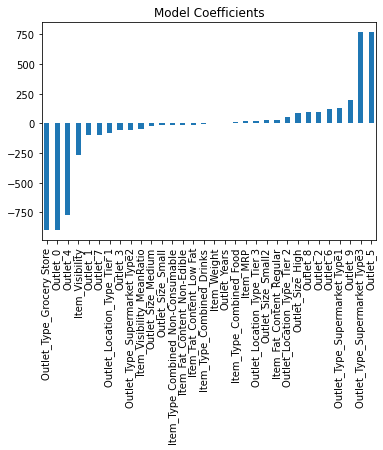

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# print predictors
alg1 = LinearRegression(normalize=True)
model_fit(alg1, train, test, predictors, target, idcols, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

Model Report
RMSE On Train 1128.2943486560173
CV Score - Mean 1129.8475742263984 | Standard Deviation 44.603686107108594 | Min 1075.9663261840399 | Max 1216.4551785804297


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


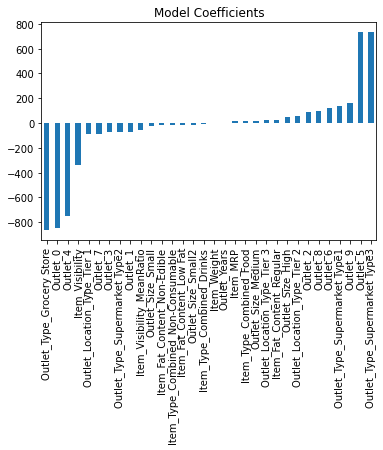

In [ ]:
alg2 = Ridge(alpha=0.05,normalize=True)
model_fit(alg2, train, test, predictors, target, idcols, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

Model Report
RMSE On Train 1057.7284245217386
CV Score - Mean 1092.3321638182606 | Standard Deviation 45.389096879027434 | Min 1010.6392702746468 | Max 1183.5608675645485


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


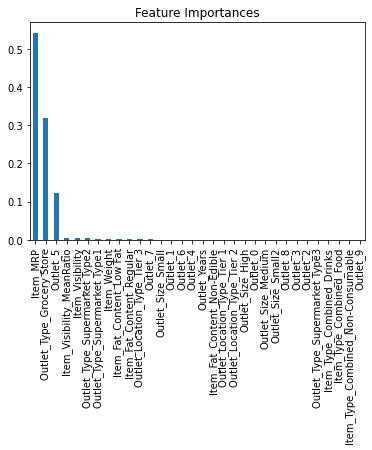

In [ ]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+idcols]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
model_fit(alg3, train, test, predictors, target, idcols, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

Model Report
RMSE On Train 1068.0118862996194
CV Score - Mean 1082.6842885576286 | Standard Deviation 43.776972546096836 | Min 1019.7208454489869 | Max 1162.3570524186769


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


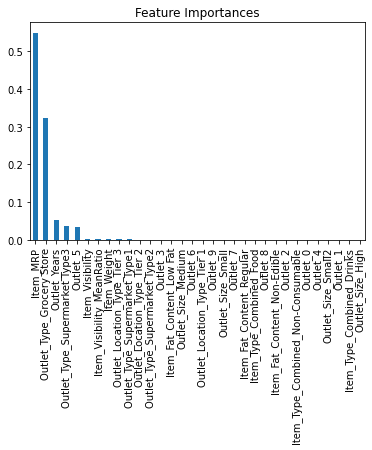

In [ ]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+idcols]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
model_fit(alg6, train, test, predictors, target, idcols, 'alg6.csv')
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')

In [ ]:
import xgboost as xgb
alg15 = xgb.XGBRegressor(learning_rate = 0.05, n_estimators = 100, reg_lambda = 10, gamma=0, max_depth=3)

predictors = [x for x in train.columns if x not in [target]+idcols]

model_fit(alg15, train, test, predictors, target, idcols, 'alg15.csv')

[09:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
